In [364]:
# Import von Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

## Übung 2.1

##### Input-Parameter:

In [365]:
# Input - Parameter
Pv_kWp = 10
Zinssatz = 0.06
Systemkosten = 800
Betriebskosten = 10     #€/(kWp a)
Lebensdauer = 20        #Jahre

##### Einlesen der gewünschten Daten

In [366]:
#Normierte PV-Einspeisung
dfEinspeisung = pd.read_csv("PV_Einspeisung.csv")

#Preise 2023 (ct/kWh)
dfPeise = pd.read_csv("ENTSOE_prices_for_2023_in_ct_per_kWh.csv", delimiter =";")

#Auswahl des Landes
Preise = dfPeise["AT"]

##### a.) Barwert berechnen

In [367]:
def Barwert_ohne_OeMAG(dfEinspeisung, Preise, Pv_kWp, Systemkosten, Zinssatz, Betriebskosten, Lebensdauer):
    
    #Erlös
    Erlöse_array = dfEinspeisung["0"] * Pv_kWp / 100 * Preise
    Erlöse = np.sum(Erlöse_array)
    
    #Nettobarwertmethode (NPV) ohne OEMAG
    NPV = np.zeros(shape=(Lebensdauer,1))
    time = np.arange(1, Lebensdauer)
    NPV[0][0] = -Pv_kWp*Systemkosten          #Investitionskosten zum Zeitpunkt 0 in EUR
    NPV[1:, 0] = NPV[0][0] + np.cumsum((Erlöse - Betriebskosten) / ((1 + Zinssatz) ** time))

    #Alternative:
    #for i in range(19):
        #NPV[i+1][0] = NPV[i][0] + (Erlöse - Betriebskosten)/((1+Zinssatz)**(i+1))

    fig, ax = plt.subplots()
    ax.bar(np.arange(1, 21), NPV.flatten(), zorder=2)
    ax.set_title("Barwertberechnung ohne OeMag")
    ax.set_xlabel('t in Years')
    ax.set_ylabel('Yield in €')
    ax.grid(True, zorder=1)
    plt.show()
    

##### b.) Barwert berechnen mit OeMAG:

In [368]:
def Barwert_mit_OeMAG(dfEinspeisung, Preise, Pv_kWp, Systemkosten, Zinssatz, Betriebskosten, Lebensdauer):
    
    #Erlös
    Erlöse_array = dfEinspeisung["0"] * Pv_kWp / 100 * Preise
    Erlöse = np.sum(Erlöse_array)
    
    #Nettobarwertmethode (NPV) ohne OEMAG
    NPV = np.zeros(shape=(Lebensdauer,1))
    time = np.arange(1, Lebensdauer)
    
    #Investitionskosten zum Zeitpunkt 0 in EUR
    NPV[0][0] = -Pv_kWp*Systemkosten + np.minimum(195*Pv_kWp,(0.3*Pv_kWp*Systemkosten)) 
    NPV[1:, 0] = NPV[0][0] + np.cumsum((Erlöse - Betriebskosten) / ((1 + Zinssatz) ** time))
    
    fig, ax = plt.subplots()
    ax.bar(np.arange(1, 21), NPV.flatten(), zorder=2)
    ax.set_title("Barwertberechnung mit OeMag")
    ax.set_xlabel('t in Years')
    ax.set_ylabel('Yield in €')
    ax.grid(True, zorder=1)
    plt.show()

##### c.) Barwert mit normierten Preisen:

In [369]:
def Barwert_ohne_OeMAG_Normiert(dfEinspeisung, Preise, Pv_kWp, Systemkosten, Zinssatz, Betriebskosten, Lebensdauer):

    #Durchschnittspreis über das gesamter Jahr
    Preise_NORM = np.mean(Preise)

    #Erlöse berechnen
    Erlöse_array = dfEinspeisung["0"] * Pv_kWp / 100 * Preise_NORM
    Erlöse = np.sum(Erlöse_array)
    
    #Nettobarwertmethode (NPV) ohne OEMAG mit normierten Preis
    NPV = np.zeros(shape=(Lebensdauer,1))
    time = np.arange(1, Lebensdauer)
    
    #Investitionskosten zum Zeitpunkt 0 in EUR
    NPV[0][0] = -Pv_kWp*Systemkosten 
    NPV[1:, 0] = NPV[0][0] + np.cumsum((Erlöse - Betriebskosten) / ((1 + Zinssatz) ** time))
    
    fig, ax = plt.subplots()
    ax.bar(np.arange(1, 21), NPV.flatten(), zorder=2)
    ax.set_title("Barwertberechnung ohne OeMag mit normierten Preisen")
    ax.set_xlabel('t in Years')
    ax.set_ylabel('Yield in €')
    ax.grid(True, zorder=1)
    plt.show()

In [370]:
def Barwert_mit_OeMAG_Normiert(dfEinspeisung, Preise, Pv_kWp, Systemkosten, Zinssatz, Betriebskosten, Lebensdauer):
    
    #Durchschnittspreis über das gesamter Jahr
    Preise_NORM = np.mean(Preise)

    #Erlöse berechnen
    Erlöse_array = dfEinspeisung["0"] * Pv_kWp / 100 * Preise_NORM
    Erlöse = np.sum(Erlöse_array)
    
    #Nettobarwertmethode (NPV) ohne OEMAG mit normierten Preis
    NPV = np.zeros(shape=(Lebensdauer,1))
    time = np.arange(1, Lebensdauer)#Nettobarwertmethode (NPV) mit OEMAG
    NPV[0][0] = -Pv_kWp*Systemkosten + np.minimum(195*Pv_kWp,(0.3*Pv_kWp*Systemkosten))
    NPV[1:, 0] = NPV[0][0] + np.cumsum((Erlöse - Betriebskosten) / ((1 + Zinssatz) ** time))

    fig, ax = plt.subplots()
    ax.bar(np.arange(1, 21), NPV.flatten(), zorder=2)
    ax.set_title("Barwertberechnung mit OeMag mit normierten Preisen")
    ax.set_xlabel('t in Years')
    ax.set_ylabel('Yield in €')
    ax.grid(True, zorder=1)
    plt.show()

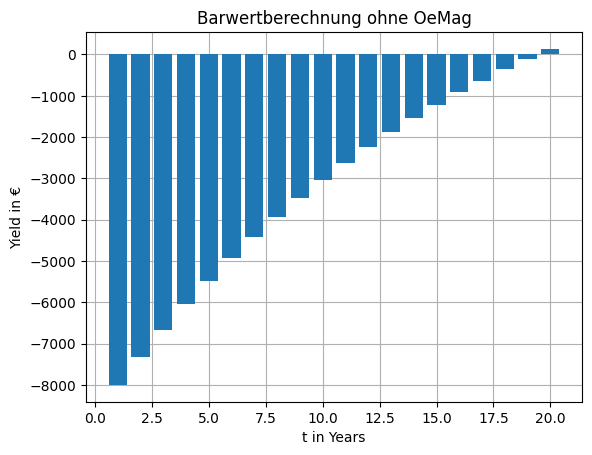

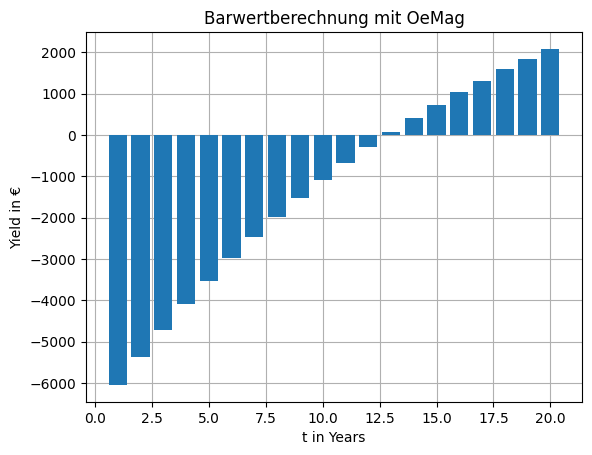

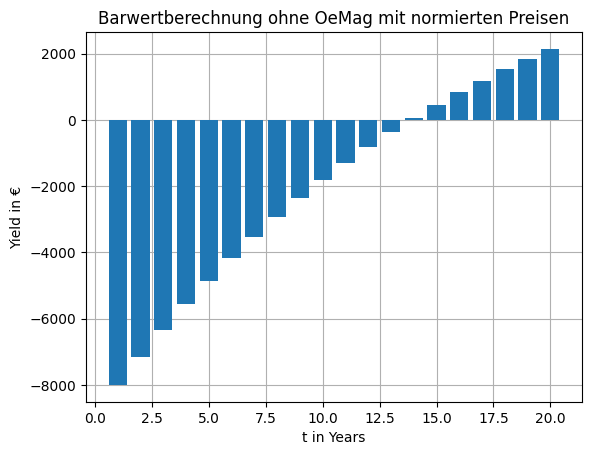

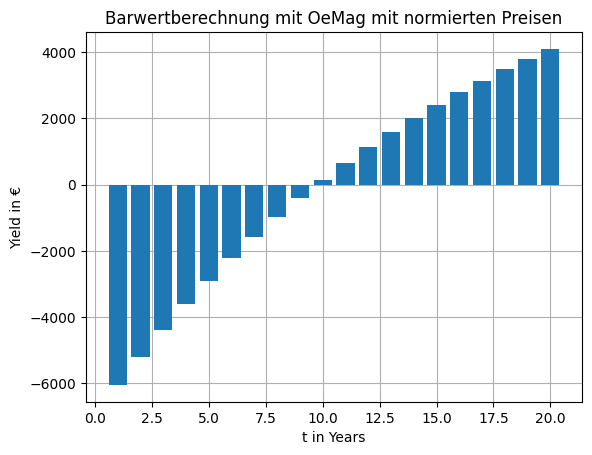

In [371]:
Barwert_ohne_OeMAG(dfEinspeisung, Preise, Pv_kWp, Systemkosten, Zinssatz, Betriebskosten, Lebensdauer)
Barwert_mit_OeMAG(dfEinspeisung, Preise, Pv_kWp, Systemkosten, Zinssatz, Betriebskosten, Lebensdauer)
Barwert_ohne_OeMAG_Normiert(dfEinspeisung, Preise, Pv_kWp, Systemkosten, Zinssatz, Betriebskosten, Lebensdauer)
Barwert_mit_OeMAG_Normiert(dfEinspeisung, Preise, Pv_kWp, Systemkosten, Zinssatz, Betriebskosten, Lebensdauer)

## Übung 2.2

##### Input-Parameter & gewünschte Daten:

In [372]:
Anlage_Pv = 5                                           # in kWp
dfProduktion = pd.read_csv("PV_Profil_leistung_2.csv")  # Produktion der Anlage in kW/kWp
dfVerbrauch = pd.read_csv("LeistungHaushalte.csv", delimiter = ",")
dfVerbrauch_kWh = dfVerbrauch / 1000                    # Umrechnung Wh in kWh

# Auswählen Verbrauch vom gewünschten Haushalt:
Haushalt1 = dfVerbrauch_kWh["1"]
Haushalt2 = dfVerbrauch_kWh["2"]


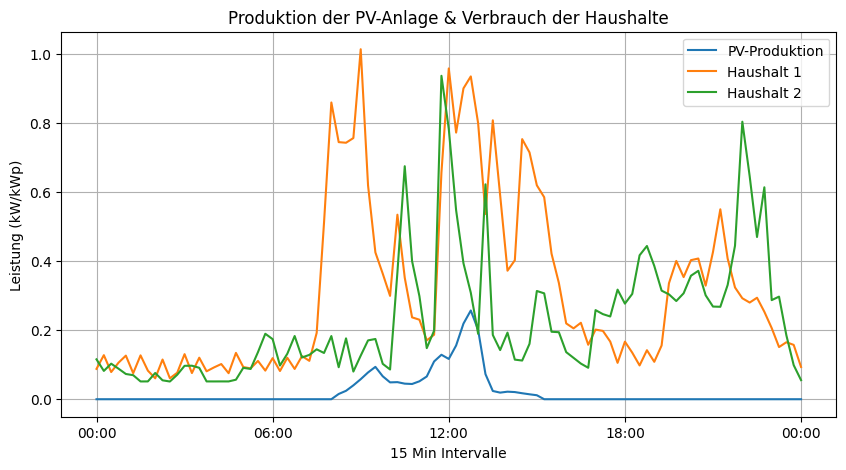

In [373]:
########################################
# Test zur leichteren Veranschaulichung
# Auswählen der ersten 96 Werte (einen Tag) (01.01.2023)
dfProduktion_day = dfProduktion.head(97)
dfVerbrauch_day = dfVerbrauch_kWh.head(97)

# Plot Produktion der PV-Anlage & Verbrauchsdaten der Haushalte
plt.figure(figsize=(10, 5))
plt.plot(dfProduktion_day["Produktion"], label="PV-Produktion")
plt.plot(dfVerbrauch_day["1"], label="Haushalt 1")
plt.plot(dfVerbrauch_day["2"], label="Haushalt 2")
plt.xlabel("15 Min Intervalle")
plt.ylabel("Leistung (kW/kWp)")
plt.title("Produktion der PV-Anlage & Verbrauch der Haushalte")
plt.xticks([0, 24, 48, 72, 96], ["00:00", "06:00", "12:00", "18:00", "00:00"])  # Beschriftung der x-Achse
plt.legend()
plt.grid(True)
plt.show()


##### a.) Eigenverbrauch & Überschusseinspeisung:

In [374]:
def Eigenverbrauch_Einspeisung_Haushalt(Haushalt, Produktion, Pv_kWp):
    Eigenverbrauch = 0
    Überschusseinspeisung = 0
    
    #Sollen wir die Pv-KWp berücksichtigen ??? Wieso kriegen wir hohe werte ?
    Produktion_Anlage = Pv_kWp * Produktion
    
    # range(1,97) Erster Tag
    # range(1,2977) Monat mit 31 Tagen
    # range(1,2881) Monat mit 30 Tagen    
    for i in range(len(Haushalt)):
        if Produktion_Anlage[i] <= Haushalt[i]:
            Eigenverbrauch += Produktion_Anlage[i]
        else:
            Eigenverbrauch += Haushalt[i]
            Überschusseinspeisung += Produktion_Anlage[i] - Haushalt[i]
            
    #Alternative:
    #for pv, verbrauch in zip(Produktion_Anlage, Haushalt):
    #    Eigenverbrauch += min(pv, verbrauch)
    #    Überschusseinspeisung += max(0, pv - verbrauch)
    
    return Eigenverbrauch, Überschusseinspeisung

In [375]:
# Eigenverbrauch & Überschusseinspeisung Haushalt 1
Eigenverbrauch_H1, Überschusseinspeisung_H1 = Eigenverbrauch_Einspeisung_Haushalt(Haushalt1, dfProduktion["Produktion"], Anlage_Pv)
print("Eigenverbrauch Haushalt 1:", Eigenverbrauch_H1, "kWh")
print("Überschusseinspeisung Haushalt 1:", Überschusseinspeisung_H1, "kWh")

# Eigenverbrauch & Überschusseinspeisung Haushalt 2
Eigenverbrauch_H2, Überschusseinspeisung_H2 = Eigenverbrauch_Einspeisung_Haushalt(Haushalt2, dfProduktion["Produktion"], Anlage_Pv)
print("Eigenverbrauch Haushalt 2:", Eigenverbrauch_H2, "kWh")
print("Überschusseinspeisung Haushalt 2:", Überschusseinspeisung_H2, "kWh")

Eigenverbrauch Haushalt 1: 3282.1328091265 kWh
Überschusseinspeisung Haushalt 1: 15740.346546000026 kWh
Eigenverbrauch Haushalt 2: 2450.651141626509 kWh
Überschusseinspeisung Haushalt 2: 16571.828213499994 kWh


### b.) Eigenverbrauchsanteil & Deckungsgrade

In [388]:
#Deckungsgrad beschreibt die Unabhängigkeit von anderen Energiequellen als der Sonne

def Anteile_Verbrauch_Deckungsgrad(Haushalt, Produktion, Anlage_Pv):
    Eigenverbrauchsanteile = []
    Deckungsgrade = []

    for i in range(1, 211, 1):  # Anlagengröße von 0 bis 20 kWp
        Anlage_size = i/10      # Schritte von 0.1kWp
        Eigenverbrauch, Überschusseinspeisung = Eigenverbrauch_Einspeisung_Haushalt(Haushalt, Produktion, Anlage_size)
        
        Gesamtproduktion = Produktion.sum() * Anlage_size
        Eigenverbrauchsanteil = Eigenverbrauch / Gesamtproduktion if Gesamtproduktion > 0 else 0
        Deckungsgrade.append(Überschusseinspeisung / Gesamtproduktion if Gesamtproduktion > 0 else 0)
        Eigenverbrauchsanteile.append(Eigenverbrauchsanteil)

    return Eigenverbrauchsanteile, Deckungsgrade

In [389]:
# Berechnen der Anteile für H1 & H2
Eigenverbrauchsanteile_H1, Deckungsgrade_H1 = Anteile_Verbrauch_Deckungsgrad(Haushalt1, dfProduktion["Produktion"], Anlage_Pv)
Eigenverbrauchsanteile_H2, Deckungsgrade_H2 = Anteile_Verbrauch_Deckungsgrad(Haushalt2, dfProduktion["Produktion"], Anlage_Pv)

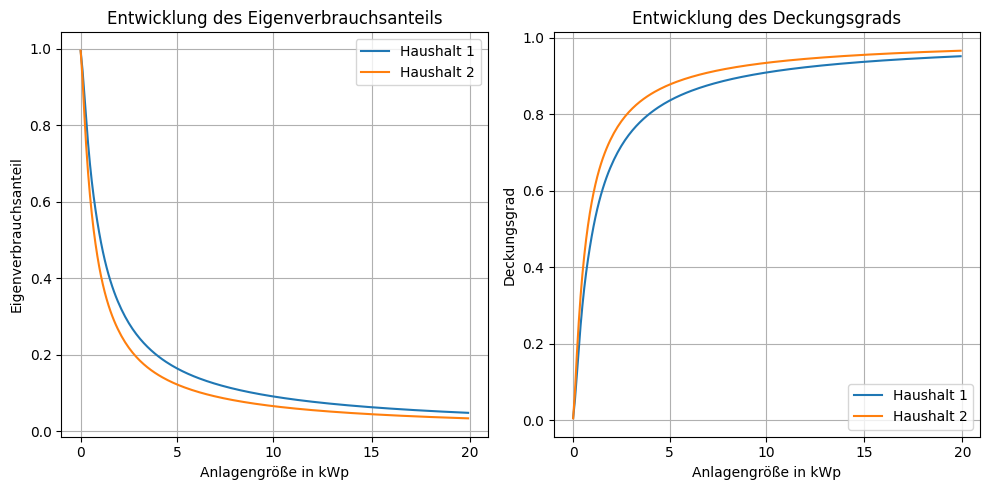

In [390]:
# Diagramme erstellen
plt.figure(figsize=(10, 5))

# Eigenverbrauchsanteile
plt.subplot(1, 2, 1)
plt.plot(range(1, 211), Eigenverbrauchsanteile_H1, label='Haushalt 1')
plt.plot(range(1, 211), Eigenverbrauchsanteile_H2, label='Haushalt 2')
plt.xlabel('Anlagengröße in kWp')
plt.ylabel('Eigenverbrauchsanteil')
plt.title('Entwicklung des Eigenverbrauchsanteils')
plt.xticks([1, 53 , 105, 158, 211], ["0", "5", "10", "15", "20"])
plt.grid()
plt.legend()

# Deckungsgrade
plt.subplot(1, 2, 2)
plt.plot(range(1, 211), Deckungsgrade_H1, label='Haushalt 1')
plt.plot(range(1, 211), Deckungsgrade_H2, label='Haushalt 2')
plt.xlabel('Anlagengröße in kWp')
plt.xticks([1, 53 , 105, 158, 211], ["0", "5", "10", "15", "20"])
plt.ylabel('Deckungsgrad')
plt.title('Entwicklung des Deckungsgrads')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


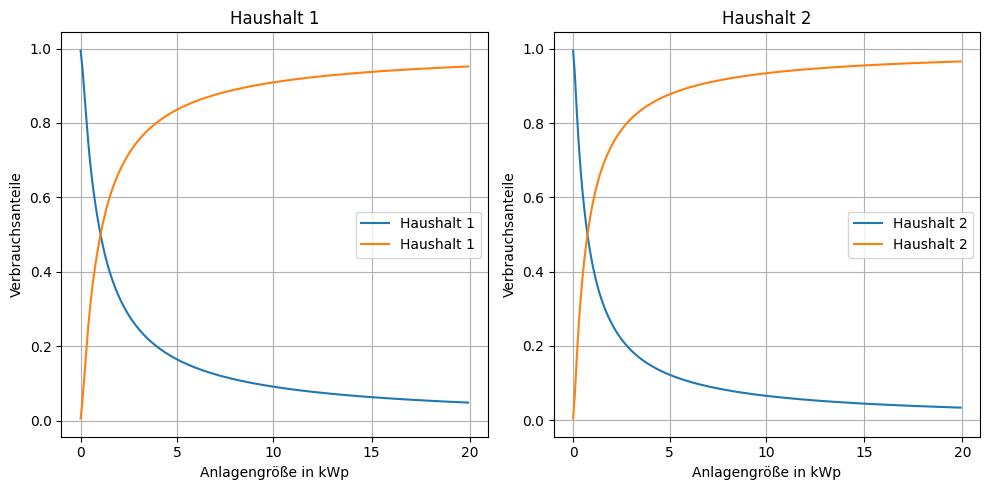

In [386]:
# Diagramme erstellen
plt.figure(figsize=(10, 5))

# Haushalt1
plt.subplot(1, 2, 1)
plt.plot(range(1, 211), Anteile_H1, label='Haushalt 1')
plt.plot(range(1, 211), Deckungsgrade_H1, label='Haushalt 1')
plt.xlabel('Anlagengröße in kWp')
plt.ylabel('Verbrauchsanteile')
plt.title('Haushalt 1')
plt.xticks([1, 53 , 105, 158, 211], ["0", "5", "10", "15", "20"])
plt.grid()
plt.legend()

# Haushalt2
plt.subplot(1, 2, 2)
plt.plot(range(1, 211), Anteile_H2, label='Haushalt 2')
plt.plot(range(1, 211), Deckungsgrade_H2, label='Haushalt 2')
plt.xlabel('Anlagengröße in kWp')
plt.xticks([1, 53 , 105, 158, 211], ["0", "5", "10", "15", "20"])
plt.ylabel('Verbrauchsanteile')
plt.title('Haushalt 2')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

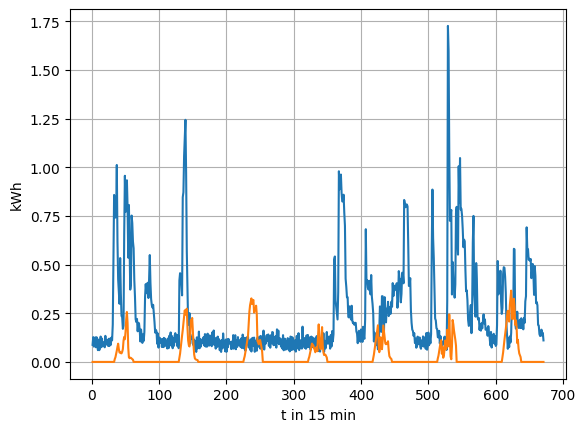

In [380]:
fig, ax = plt.subplots()
ax.plot(np.arange(1, 672), dfVerbrauch["1"][0:671]/1000,  label="Verbrauch Haushalt1")
ax.plot(np.arange(1, 672), dfProduktion["Produktion"][0:671],  label="PV-Produktion")
ax.set_title("")
ax.set_xlabel('t in 15 min')
ax.set_ylabel('kWh')
ax.grid(True, zorder=1)
plt.show()